# Подготовка

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import pandahouse as ph
from datetime import date, datetime, timedelta
import telegram

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# Get data

In [3]:
query = '''
        SELECT toStartOfFifteenMinutes(time) as t15,
            toDate(time) as day,
            formatDateTime(t15, '%R') as hm,
            count(distinct(user_id)) as users,
            countIf(action='view') as views,
            countIf(action='like') as likes,
            likes / views as ctr
        
        FROM {db}.feed_actions
        WHERE time > (today() - 1) AND time < toStartOfFifteenMinutes(now())      
        GROUP BY t15, day, hm
        ORDER BY t15
        
        '''

df = ph.read_clickhouse(query, connection = connection)
df

,t15,day,hm,users,views,likes,ctr
0,2023-07-18 00:00:00,2023-07-18,00:00,407,6295,1360,0.216044
1,2023-07-18 00:15:00,2023-07-18,00:15,378,5923,1283,0.216613
2,2023-07-18 00:30:00,2023-07-18,00:30,381,5827,1253,0.215033
3,2023-07-18 00:45:00,2023-07-18,00:45,371,5820,1226,0.210653
4,2023-07-18 01:00:00,2023-07-18,01:00,338,5568,1120,0.201149
...,...,...,...,...,...,...,...
159,2023-07-19 15:45:00,2023-07-19,15:45,550,6630,1299,0.195928
160,2023-07-19 16:00:00,2023-07-19,16:00,620,7122,1422,0.199663
161,2023-07-19 16:15:00,2023-07-19,16:15,618,6944,1350,0.194412
162,2023-07-19 16:30:00,2023-07-19,16:30,619,7152,1481,0.207075


# Detect anomaly

Определение функции

In [4]:
def detect_anomaly(df, metric, a=2.5, n=7):
    
    df['q25'] = df[metric].shift(1).rolling(n).quantile(0.25)
    df['q75'] = df[metric].shift(1).rolling(n).quantile(0.75)
    df['iqr'] = df['q75'] - df['q25']
    df['low'] = df['q25'] - a * df['iqr']
    df['up'] = df['q75'] + a * df['iqr']
    
    df['low'] = df['low'].rolling(n, center=True, min_periods=1).mean()
    df['up'] = df['up'].rolling(n, center=True, min_periods=1).mean()
    
    df['is_out'] = np.where((df[metric] < df['low']) | (df[metric] > df['up']), True, False)

    df['diff'] = abs((df[metric] - df[metric].shift(1)) * 100 / df[metric].shift(1))
    
    df['is_alert'] = np.where((df['is_out']) & (df['diff'] > 25), True, False )
    
    is_alert_last = df['is_alert'].iloc[-1]
    
    return df, is_alert_last


In [5]:
# проверка

df_anomaly, is_alert_last = detect_anomaly(df, 'users')
df_anomaly[df_anomaly['is_alert']]

,t15,day,hm,users,views,likes,ctr,q25,q75,iqr,low,up,is_out,diff,is_alert
24,2023-07-18 06:00:00,2023-07-18,06:00,614,8427,1724,0.204581,215.0,274.0,59.0,-29.928571,550.357143,True,46.190476,True
36,2023-07-18 09:00:00,2023-07-18,09:00,1098,14444,3008,0.208253,434.5,497.5,63.0,95.035714,922.607143,True,45.816733,True


# Текст сообщения

In [10]:
metric = 'views'

df_anomaly, is_alert_last = detect_anomaly(df, metric)
        
current_value = int(df[metric].iloc[-1])
previous = int(df[metric].iloc[-2])
diff = ((current_value - previous) * 100 / previous) 
time = df['t15'].iloc[-1]

link = 'ссылка на дашборд'
message = '\n'.join(["Обнаружена аномалия в ленте новостей", '\n', f'Метрика: {metric}', f'Время: {time}', f'Текущее значение: {current_value}',f'Отклонение от предыдущего: {diff: .2f}%', 'Подробнее:', link])
print(message)

Обнаружена аномалия в ленте новостей


Метрика: views
Время: 2023-07-18 21:15:00
Текущее значение: 8446
Отклонение от предыдущего: -6.70%
Подробнее:
http://www.example.com/


# Функция, посылающая алерты - Send alerts

In [ ]:
def send_alerts(df):
    
    my_token = '6396826757:AAFNxdR3RKdRNcHqEtBn3LkhgvDObLeMmU4' 
    bot = telegram.Bot(token=my_token) 
    chat_id = 963732064
    
    for metric in ['users', 'views', 'likes']:
        df_anomaly, is_alert_last = detect_anomaly(df, metric)
        
        if is_alert_last:
            current_value = int(df[metric].iloc[-1])
            previous = int(df[metric].iloc[-2])
            diff = round((current_value / previous) * 100)
            
            link = [inline URL](http://www.example.com/)
            message = '\n'.join("*Внимание! Обнаружена аномалия*", '\n', 'Метрика: {metric}', 'Текущее значение {current_value}','Отклонение от прошлого значения: {diff}%', 'Подробнее:', link)
            
            bot.sendMessage(chat_id=chat_id, text=message, parse_mode='Markdown')
            
            fig, ax = plt.subplots(1, 1, figsize=(16,8))
            sns.lineplot(data=df_anomaly, x= 't15', y= metric, color='blue',label=f'{metric}')
            sns.lineplot(data=df_anomaly, x= 't15', y= 'low', color='grey', alpha=0.25, label='Границы нормы')
            sns.lineplot(data=df_anomaly, x= 't15', y= 'up', color='grey', alpha=0.25)
            ax.fill_between(x= df_anomaly['t15'], y1=df_anomaly['low'], y2=df_anomaly['up'], color='grey', alpha=0.25)
            ax.set_title(f'{metric}')
            ax.set_xlabel('Время')
            ax.set_ylabel(f'{metric}')
            sns.scatterplot(x= df_anomaly[df_anomaly['is_alert']]['t15'], y= df_anomaly[df_anomaly['is_alert']][metric], color='red', label='Аномалии')
            ax.set_xticks([min(df_anomaly['t15']), df_anomaly['t15'].iloc[len(df_anomaly['t15'])// 2], max(df_anomaly['t15'])])
            
           
            plt.xticks(df_anomaly[df_anomaly['is_alert']]['t15'])
            plot_object = io.BytesIO()
            fig.savefig(plot_object)
            plot_object.seek(0)
            plot_object.name = f'{metric}.png'
            plt.close()
            
            bot.sendPhoto(chat_id=chat_id, photo=plot_object)
            
            
    


# Lineplot

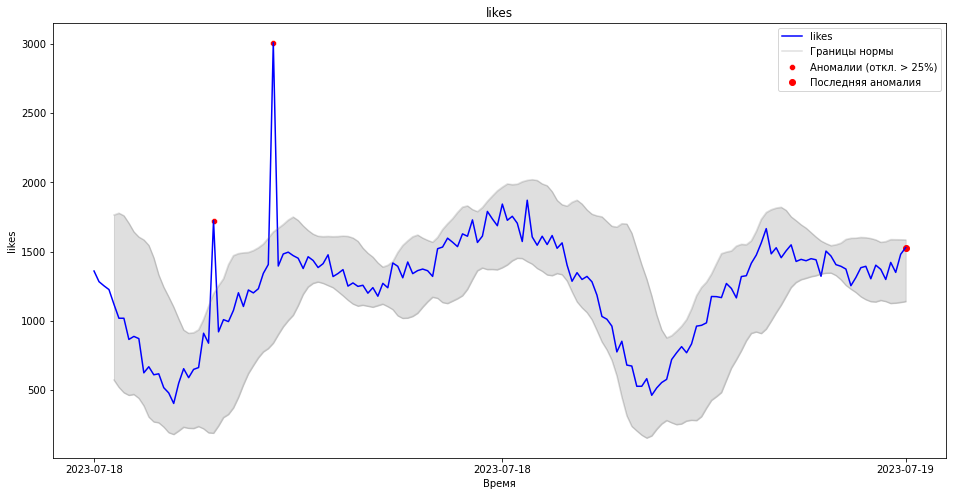

In [8]:
# проверка для ЛЮБОГО последнего значения (без проверки флага)

metric = 'likes'
#'users'
#'likes'

df_anomaly, is_alert_last = detect_anomaly(df, metric)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.lineplot(data=df_anomaly, x= 't15', y= metric, color='blue',label=f'{metric}')
sns.lineplot(data=df_anomaly, x= 't15', y= 'low', color='grey', alpha=0.25, label='Границы нормы')
sns.lineplot(data=df_anomaly, x= 't15', y= 'up', color='grey', alpha=0.25)
ax.fill_between(x= df_anomaly['t15'], y1=df_anomaly['low'], y2=df_anomaly['up'], color='grey', alpha=0.25)
ax.set_title(f'{metric}')
ax.set_xlabel('Время')
ax.set_ylabel(f'{metric}')
sns.scatterplot(x= df_anomaly[df_anomaly['is_alert']]['t15'], y= df_anomaly[df_anomaly['is_alert']][metric], color='red', label='Аномалии (откл. > 25%)')
plt.scatter(x= df_anomaly['t15'].iloc[-1], y= df_anomaly[metric].iloc[-1], color='red', marker = 'o', label='Последняя аномалия')
ax.set_xticks([min(df_anomaly['t15']), df_anomaly['t15'].iloc[len(df_anomaly['t15'])// 2], max(df_anomaly['t15'])])
plt.legend()


In [ ]:
# если нужно изменить лейблы тиков

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

# df Messages

In [9]:
query = '''
SELECT toStartOfFifteenMinutes(time) as t15,
    toDate(time) as day,
    formatDateTime(t15, '%R') as hm,
    count(distinct(user_id)) as users,
    count(reciever_id) as messages_sent

    FROM {db}.message_actions
    WHERE time > (today() - 1) AND time < toStartOfFifteenMinutes(now())      
    GROUP BY t15, day, hm
    ORDER BY t15

    '''

df_message = ph.read_clickhouse(query, connection = connection)
df_message

,t15,day,hm,users,messages_sent
0,2023-07-18 00:00:00,2023-07-18,00:00,57,60
1,2023-07-18 00:15:00,2023-07-18,00:15,79,88
2,2023-07-18 00:30:00,2023-07-18,00:30,66,72
3,2023-07-18 00:45:00,2023-07-18,00:45,74,84
4,2023-07-18 01:00:00,2023-07-18,01:00,57,64
...,...,...,...,...,...
159,2023-07-19 15:45:00,2023-07-19,15:45,147,185
160,2023-07-19 16:00:00,2023-07-19,16:00,133,183
161,2023-07-19 16:15:00,2023-07-19,16:15,147,187
162,2023-07-19 16:30:00,2023-07-19,16:30,140,175


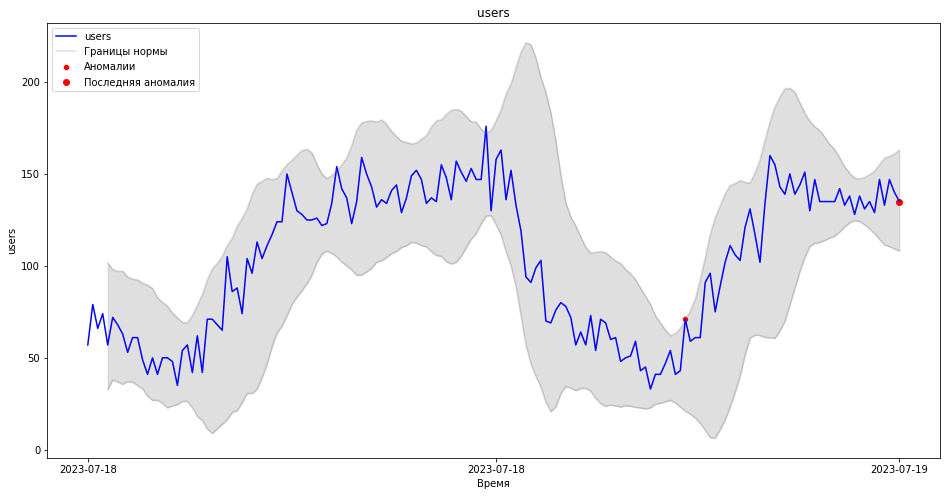

In [11]:
metric = 'users'
#'messages_sent'
#'users'

df_anomaly, is_alert_last = detect_anomaly(df_message, metric)


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.lineplot(data=df_anomaly, x= 't15', y= metric, color='blue',label=f'{metric}')
sns.lineplot(data=df_anomaly, x= 't15', y= 'low', color='grey', alpha=0.25, label='Границы нормы')
sns.lineplot(data=df_anomaly, x= 't15', y= 'up', color='grey', alpha=0.25)
ax.fill_between(x= df_anomaly['t15'], y1=df_anomaly['low'], y2=df_anomaly['up'], color='grey', alpha=0.25)
ax.set_title(f'{metric}')
ax.set_xlabel('Время')
ax.set_ylabel(f'{metric}')
sns.scatterplot(x= df_anomaly[df_anomaly['is_alert']]['t15'], y= df_anomaly[df_anomaly['is_alert']][metric], color='red', label='Аномалии')
plt.scatter(x= df_anomaly['t15'].iloc[-1], y= df_anomaly[metric].iloc[-1], color='red', marker = 'o', label='Последняя аномалия')
ax.set_xticks([min(df_anomaly['t15']), df_anomaly['t15'].iloc[len(df_anomaly['t15'])// 2], max(df_anomaly['t15'])])
plt.legend()



In [18]:
df_anomaly

,t15,day,hm,users,messages_sent,q25,q75,iqr,low,up,is_out,diff,is_alert
0,2023-07-17 00:00:00,2023-07-17,00:00,56,64,NaN,NaN,NaN,NaN,NaN,False,NaN,False
1,2023-07-17 00:15:00,2023-07-17,00:15,72,87,NaN,NaN,NaN,NaN,NaN,False,28.571429,False
2,2023-07-17 00:30:00,2023-07-17,00:30,70,74,NaN,NaN,NaN,NaN,NaN,False,2.777778,False
3,2023-07-17 00:45:00,2023-07-17,00:45,69,76,NaN,NaN,NaN,NaN,NaN,False,1.428571,False
4,2023-07-17 01:00:00,2023-07-17,01:00,59,66,NaN,NaN,NaN,34.500000,94.500000,False,14.492754,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2023-07-18 21:00:00,2023-07-18,21:00,136,171,147.0,160.5,13.5,107.785714,193.500000,False,16.564417,False
181,2023-07-18 21:15:00,2023-07-18,21:15,152,180,141.5,160.5,19.0,100.035714,199.035714,False,11.764706,False
182,2023-07-18 21:30:00,2023-07-18,21:30,133,170,141.5,160.5,19.0,94.583333,204.583333,False,12.500000,False
183,2023-07-18 21:45:00,2023-07-18,21:45,119,144,134.5,160.5,26.0,88.700000,209.900000,False,10.526316,False
